# The Very Basics of Musical Instruments Classification using Machine Learning
## MFCC, SVM 

<br>

<p align="left">
<img src="./img/businesscard.jpg" width="300px" alt="Business Card" align="left" >
</p>
<br>



In [2]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/6XmEj8sqg94" 
frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture"></iframe>

## Imports

In [3]:
# Imports

#General
import numpy as np
import pickle
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib

# Random Seed
from numpy.random import seed
seed(1)

# Audio
import librosa.display, librosa

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Configurations
path='./audio/london_phill_dataset_multi/'

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Auxiliary Functions

In [4]:
# Function to Display a Website
def show_web(url):
    html_code='<center><iframe src="%s" width="800" height="600" frameborder="0" marginheight="0" marginwidth="0">Loading...</iframe></center>' \
		% (url)
    display(HTML(html_code))

## Get filenames

In [5]:
# Get files in data path

files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.wav'):
        files.append(os.path.join(root, filename))
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 711 audio files in ./audio/london_phill_dataset_multi/


## Prepare labels from filenames

In [6]:
# Get Labels
labels =[]
classes=['flute', 'sax', 'oboe', 'cello', 'trumpet', 'viola', 'violin', 'percussion']
color_dict={'cello':'blue', 'flute':'red', 'oboe':'green', 'trumpet':'black', 'sax':'magenta', \
            'viola':'yellow', 'violin':'purple', 'percussion':'pink'}
color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

## Encode Labels

In [7]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

7 classes: cello, flute, oboe, sax, trumpet, viola, violin


## Parameters for MFCC

In [8]:
# Parameters
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing
n_neighbors=1       # Number of neighbors for kNN Classifier

## Function to Calculate Audio Features: MFCC

In [9]:
# Define Function to Calculate MFCC, Delta_MFCC and Delta2_MFCC
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    #feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector

## Load audio files, calculate features and create feature vectors

In [10]:
# Load audio files, calculate features and create feature vectors
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    if np.mod(i, 100) == 99:
        # print ("get %d of %d = %s"%(i+1, len(files), f))
        print ("get %d of %d"%(i+1, len(files)))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d feature vectors"%len(feature_vectors))

get 100 of 711
get 200 of 711
get 300 of 711
get 400 of 711
get 500 of 711
get 600 of 711
get 700 of 711
Calculated 711 feature vectors


## Standardization: Zero-Mean and Unit-Variance

In [11]:
# Scale features using Standard Scaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
scaled_feature_vectors1 = (feature_vectors-np.mean(feature_vectors))/np.std(feature_vectors)
print("Feature vectors 0 shape:",scaled_feature_vectors.shape)
print("Feature vectors 1 shape:",scaled_feature_vectors1.shape)

Feature vectors 0 shape: (711, 13)
Feature vectors 1 shape: (711, 13)


## Save / Load Feature Vector

In [12]:
filename="mfcc_feature_vectors.pl"
# Load mfcc features from saved file
# with open(filename, "rb") as f:
#    scaled_feature_vectors = pickle.load( open( filename, "rb" ) )

# Save feature_vectors for future use
with open(filename, "wb") as f:
    pickle.dump( scaled_feature_vectors, f)

## Train and Test Sets

In [13]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [14]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)
print("test_classes:",test_classes)

train_set shape: (533, 13)
test_set shape: (178, 13)
train_classes shape: (533,)
test_classes shape: (178,)
test_classes: [3 0 1 4 4 0 3 4 2 1 6 4 5 1 3 3 2 3 2 6 4 3 6 3 3 3 0 5 2 3 4 4 4 6 2 3 2
 4 0 3 0 4 4 3 4 1 3 1 4 2 1 4 5 6 2 6 2 5 3 2 5 2 0 3 2 6 5 5 0 1 2 1 5 2
 5 3 5 1 2 4 5 5 6 6 2 5 4 5 4 5 5 3 3 0 6 6 6 0 2 0 1 1 1 6 6 1 1 5 0 0 5
 6 4 6 0 0 5 0 6 0 5 5 3 1 6 5 6 0 0 2 6 1 3 2 1 1 4 0 5 4 1 3 1 2 0 0 0 4
 3 0 6 0 2 6 2 0 2 6 4 1 5 6 6 2 3 2 1 0 1 6 5 4 1 1 4 3 6 4]


## SVM Classification

In [15]:
# SVM
#model_svm = LinearSVC(random_state=0, tol=1e-5, max_iter=5000)
svclassifier = SVC(kernel='rbf', C = 10.0, gamma=0.1) 
svclassifier1 = SVC(kernel='rbf', C = 10.0, gamma=0.1) 

In [16]:
# SVM
#model_svm.fit(train_set, train_classes);
svclassifier.fit(train_set, train_classes);
svclassifier1.fit(scaled_feature_vectors1, classes_num);

### Save / Load Trained Model

In [17]:
# Save
joblib.dump(svclassifier, 'trainedSVM.joblib')
#Load
#svclassifier = joblib.load('filename.joblib') 

['trainedSVM.joblib']

In [18]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = svclassifier.predict(test_set)
print("Predicted Label: ", predicted_labels)

Predicted Label:  [3 0 1 4 4 0 3 4 2 1 6 4 5 1 3 5 2 3 2 6 4 3 6 3 3 3 0 5 2 3 4 4 4 6 2 3 2
 4 0 3 0 4 4 5 4 1 6 1 4 2 1 4 5 6 2 6 2 5 3 2 5 2 0 3 2 6 5 5 0 1 2 1 5 2
 5 3 5 1 2 4 5 5 6 6 2 5 4 5 4 5 5 3 3 0 6 6 6 0 2 0 1 1 1 6 6 1 1 5 0 0 5
 6 4 6 0 0 5 0 6 0 5 5 3 1 6 5 6 0 0 2 6 1 3 2 1 1 4 0 5 4 1 3 1 2 0 0 0 4
 3 0 6 6 2 6 2 0 2 6 4 1 5 0 6 2 3 2 1 0 1 6 5 4 1 1 4 3 6 4]


## Evaluation

In [19]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.96153846 1.         1.         0.88       1.         1.
 0.96296296]
Precision:  [0.96153846 1.         1.         1.         1.         0.92592593
 0.92857143]
F1-Score:  [0.96153846 1.         1.         0.93617021 1.         0.96153846
 0.94545455]
Accuracy: 0.97  , 173
Number of samples: 178


In [20]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [21]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

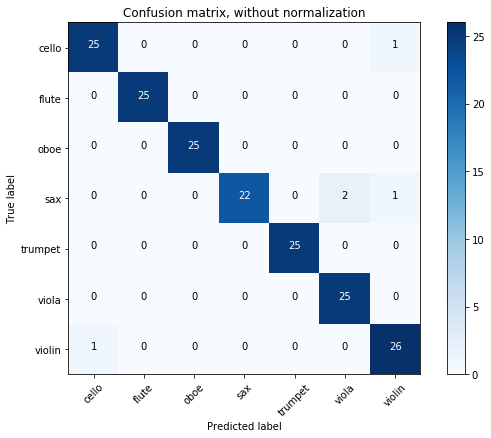

In [22]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [23]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [24]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

['sax' 'sax' 'sax' 'cello' 'violin']
[5 5 6 6 0]
['viola' 'viola' 'violin' 'violin' 'cello']
['./audio/london_phill_dataset_multi/sax/saxophone_Gs3_05_pianissimo_normal.mp3'
 './audio/london_phill_dataset_multi/sax/saxophone_Ds4_05_pianissimo_subtone.mp3'
 './audio/london_phill_dataset_multi/sax/saxophone_A3_1_pianissimo_normal.mp3'
 './audio/london_phill_dataset_multi/violin/violin_Gs5_1_piano_arco-sul-ponticello.mp3'
 './audio/london_phill_dataset_multi/violin/violin_Gs6_1_piano_natural-harmonic.mp3']


In [27]:
# Try predicting a real cello music piece
filename = '/Users/Michael/OneDrive - Georgia Institute of Technology/GaTech/2020  Summer/CS 4641/CS-4641-B-Group-6/BasicsMusicalInstrumClassifi-original/audio/Real-world_test_data/bach4.flac'
y, sr = librosa.load(filename, sr=fs)
if len(y) < 2:
    print("Error loading %s" % f)
    
feats = []
pred_freq = 2
for i in range(int(np.ceil(len(y)/sr*pred_freq))):
    ind1 = int(i*sr/pred_freq)
    ind2 = int((i+1)*sr/pred_freq-1)
    loc_y = y[ind1: ind2]
    if loc_y.max() > 0:
        loc_y /= loc_y.max() # Normalize
#     with np.printoptions(threshold=np.inf):
#         print(loc_y)
    feat = get_features(loc_y, sr)
    feats.append(feat)
scaled_feats = (feats-np.mean(feature_vectors))/np.std(feature_vectors)

label = svclassifier1.predict(scaled_feats)
occurrences = np.count_nonzero(labelencoder.inverse_transform(label) == 'cello')
# print('occurrences: ', occurrences)
print('Accuracy: ', occurrences/label.shape[0]*100, '%')
with np.printoptions(threshold=np.inf):
    print(labelencoder.inverse_transform(label))

Accuracy:  16.9811320754717 %
['cello' 'cello' 'violin' 'violin' 'viola' 'violin' 'violin' 'viola'
 'viola' 'viola' 'viola' 'viola' 'viola' 'violin' 'violin' 'violin'
 'viola' 'viola' 'violin' 'violin' 'violin' 'viola' 'viola' 'viola'
 'viola' 'violin' 'violin' 'cello' 'cello' 'viola' 'violin' 'violin'
 'violin' 'viola' 'violin' 'violin' 'violin' 'violin' 'violin' 'violin'
 'violin' 'violin' 'trumpet' 'viola' 'violin' 'cello' 'cello' 'viola'
 'violin' 'violin' 'violin' 'violin' 'viola' 'trumpet' 'violin' 'violin'
 'violin' 'violin' 'violin' 'violin' 'violin' 'viola' 'viola' 'viola'
 'violin' 'violin' 'violin' 'violin' 'violin' 'violin' 'violin' 'violin'
 'violin' 'violin' 'trumpet' 'cello' 'cello' 'cello' 'violin' 'cello'
 'cello' 'cello' 'viola' 'violin' 'viola' 'viola' 'violin' 'violin'
 'viola' 'viola' 'viola' 'viola' 'viola' 'viola' 'viola' 'violin' 'violin'
 'viola' 'viola' 'viola' 'viola' 'violin' 'violin' 'viola' 'viola' 'viola'
 'violin' 'violin' 'trumpet' 'cello' 'cello' 'viol

In [29]:
# Try predicting a real violin music piece
filename = '/Users/Michael/OneDrive - Georgia Institute of Technology/GaTech/2020  Summer/CS 4641/CS-4641-B-Group-6/BasicsMusicalInstrumClassifi-original/audio/Real-world_test_data/violin_4.flac'
y, sr = librosa.load(filename, sr=fs)
if len(y) < 2:
    print("Error loading %s" % f)
    
feats = []
pred_freq = 2
for i in range(int(np.ceil(len(y)/sr*pred_freq))):
    ind1 = int(i*sr/pred_freq)
    ind2 = int((i+1)*sr/pred_freq-1)
    loc_y = y[ind1: ind2]
    if loc_y.max() > 0:
        loc_y /= loc_y.max() # Normalize
#     with np.printoptions(threshold=np.inf):
#         print(loc_y)
    feat = get_features(loc_y, sr)
    feats.append(feat)
scaled_feats = (feats-np.mean(feature_vectors))/np.std(feature_vectors)

label = svclassifier1.predict(scaled_feats)
occurrences = np.count_nonzero(labelencoder.inverse_transform(label) == 'violin')
# print('occurrences: ', occurrences)
print('Accuracy: ', occurrences/label.shape[0]*100, '%')
with np.printoptions(threshold=np.inf):
    print(labelencoder.inverse_transform(label))

Accuracy:  68.05111821086261 %
['cello' 'cello' 'cello' 'violin' 'flute' 'flute' 'flute' 'oboe' 'flute'
 'flute' 'cello' 'cello' 'flute' 'cello' 'cello' 'cello' 'cello' 'cello'
 'cello' 'cello' 'cello' 'cello' 'cello' 'cello' 'cello' 'cello' 'cello'
 'cello' 'flute' 'violin' 'cello' 'flute' 'violin' 'violin' 'violin'
 'violin' 'violin' 'violin' 'violin' 'violin' 'violin' 'violin' 'violin'
 'violin' 'violin' 'violin' 'violin' 'violin' 'violin' 'violin' 'violin'
 'violin' 'cello' 'cello' 'cello' 'cello' 'flute' 'flute' 'cello' 'cello'
 'violin' 'violin' 'cello' 'cello' 'flute' 'flute' 'violin' 'violin'
 'violin' 'violin' 'sax' 'violin' 'violin' 'violin' 'violin' 'violin'
 'violin' 'violin' 'violin' 'violin' 'sax' 'violin' 'violin' 'cello' 'sax'
 'oboe' 'viola' 'sax' 'violin' 'violin' 'violin' 'violin' 'violin'
 'violin' 'flute' 'violin' 'violin' 'flute' 'flute' 'flute' 'sax' 'viola'
 'violin' 'violin' 'violin' 'violin' 'violin' 'violin' 'violin' 'violin'
 'violin' 'violin' 'violin' 'viol